# [MAIN QUEST 03] 🫁폐렴아 기다려라!🫁

# 🐵STEP1. 의료영상을 처리하는 CNN 기반 베이스 모델 구현 

**1. Set-up**

In [41]:
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
import os, re
warnings.filterwarnings(action='ignore')

▾변수 생성하기

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


**2. 데이터 가져오기**

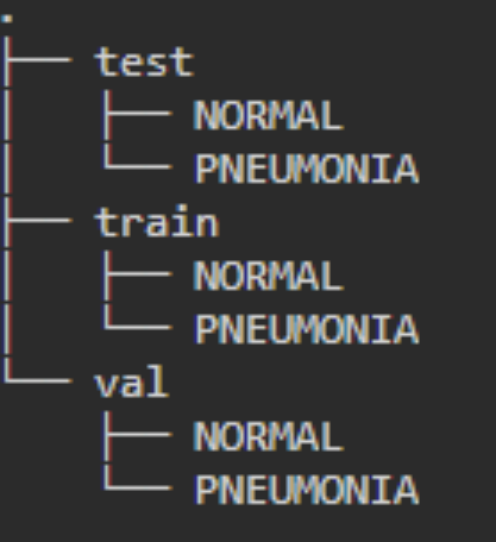

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train : 5216개 <br>
test : 624개 <br>
val :16개<br>

**개수 비: 89%, 10.7%, 0.3%**<br>
val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져오도록 ❣️<br>

train과 val에 있는 데이터를 모은 다음 train : val를 **80:20**으로 분할

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


 train: 4185개 <br>
 test: 624개 <br>
 val: 1047개<br>

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


정상 이미지: 1070개<br>
폐렴 이미지: 3115개<br>
폐렴 이미자가 3배 더 많은 **imbalance 존재** . CNN 모델은 클래스 균형이 좋을수록 학습이 원활하므로, 추후 조정할 예정 (5번에서 진행).<br> 단, test와 val 데이터셋은 평가용이므로 불균형해도 문제없음 ❣️

tf.data 인스턴스를 만들어 보자 ❣️ <br>
tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해줌! <br>
 🔍 **mini-batch**는 SGD가 무작위의 단 하나의 데이터만 고려해 loss를 계산하는 방법이 너무 성급한 방향 결정이라는 결점을 둘 이상씩의 mini-batch 고려로 완화해줌! 

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


라벨데이터가 없음 -> 라벨데이터 만들어주기 ! 

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 크기가 제각각이므로, 통일된 사이즈로 변환하여 GPU 메모리를 효율적으로 사용하기 위해 decode_img와 process_path 함수를 만듦❣️ <br>
	•	**decode_img 함수**:<br>
	•	이미지를 float 타입으로 변환하고, 크기를 조정.<br>
	•	**process_path 함수**:<br>
	•	decode_img를 사용해 이미지 변환 수행.<br>
	•	get_label을 이용해 라벨 값을 가져옴.<br>


In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

Train 데이터셋과 Validation 데이터셋을 생성합니다.<br>
또한, num_parallel_calls 파라미터에 AUTOTUNE 변수를 적용하면 데이터 처리 속도를 더욱 향상시킬 수 있습니다. 🚀

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

▾이미지가 잘 resize되었는지, 라벨이 잘 들어가 있는지 확인

In [12]:
for image, label in train_ds.take(2):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True


두 개의 데이터 불러와보니 사이즈 및 라벨이 잘 들어가 있음을 확인! <br>
이제는 위에서 train과 validation 데이터셋을 만든 것처럼 **test 데이터셋**도 만든 후 데이터 개수도 확인해보겠습니다.🚀

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


❣️TensorFlow의 tf.data 파이프라인을 사용하면 학습 데이터를 효율적으로 변환 및 처리할 수 있습니다. 이를 위해 prepare_for_training() 함수를 정의합니다.<br>
👉 prepare_for_training() 함수는 데이터를 무작위로 섞고(shuffle), 반복 가능하게 만들며(repeat), 배치 단위로 묶고(batch), CPU/GPU 활용을 최적화(prefetch)하여 학습을 효율적으로 수행하도록 도와줍니다! 🚀

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

**3. 데이터 시각화**

📊데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. <br>추출된 배치를 image와 label 데이터 셋으로 나눕니다.<br> 이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.

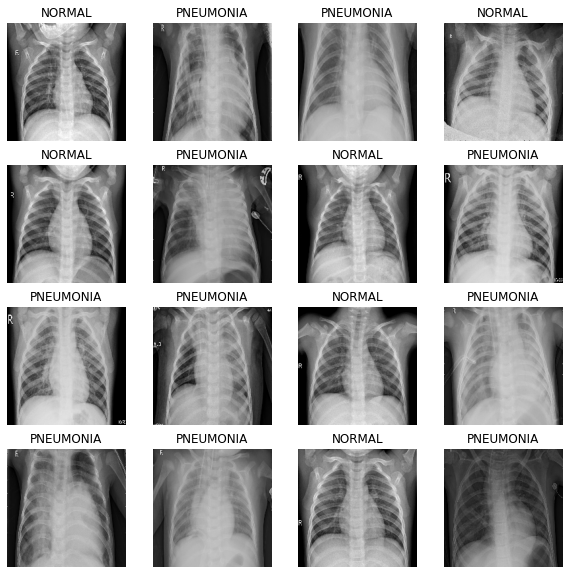

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

**4. CNN 모델링**

먼저 conv_block() 만들기 <br>
* 구성: <br>
	•	두 번의 Convolution 연산을 수행<br>
	•	Batch Normalization 적용 → Gradient Vanishing, Gradient Exploding 문제 해결<br>
	•	Max Pooling 적용 → 특징 맵 크기 축소 및 중요한 정보 추출

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

Dense Block 만들기

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

❗️이 모델의 특이점: <br>
**Batch Mormalization** + **Dropout** 이라는 두 가지 regulation 기법이 동시에 사용 -> 효과가 있을까? 

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

**5. 데이터 imbalance 처리**

⭐️데이터 불균형 해결을 위한 **Weight Balancing**: <br>
	•	‘Pneumonia’ 데이터가 ‘Normal’보다 많아 데이터가 불균형(imbalance) 함.<br>
	•	불균형한 데이터는 학습 효과를 저하시킬 수 있음.<br>
	•	Weight Balancing 기법을 사용하여 특정 클래스(덜 많은 클래스)에 더 큰 가중치를 부여해 손실(loss)을 조정.<br>
	•	Keras의 model.fit()에서 class_weight 파라미터를 활용해 클래스별 가중치를 설정 가능.<br>

아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를,<br> weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅 <br>
이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됨

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


**6. 모델 훈련**

이미지 훈련 시 GPU를 활용하므로, 먼저 **GPU**를 선택 <br>
이전에 정의한 **build_model() 함수를 호출**하여 모델을 생성 <br>
<br>
라벨이 두 개(binary classification) 이므로 손실 함수로 **"binary_crossentropy"**를 사용<br>
최적화 알고리즘(optimizer) 으로는 **'adam'**을 적용<br>
모델의 성능을 평가하기 위해 **정확도(accuracy), 정밀도(precision), 재현율(recall) 을 metrics**로 설정<br>

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

이제 model fit ❗️<br>
각 파라미터에 위에서 선언했던 변수, 데이터 셋을 가지고와 각가에 맞게 넣어주기

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 98s 323ms/step - loss: 0.3701 - accuracy: 0.8221 - precision: 0.9578 - recall: 0.7961 - val_loss: 0.7427 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 53s 202ms/step - loss: 0.2194 - accuracy: 0.9191 - precision: 0.9733 - recall: 0.9163 - val_loss: 1.0684 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 201ms/step - loss: 0.2240 - accuracy: 0.9181 - precision: 0.9733 - recall: 0.9151 - val_loss: 0.7333 - val_accuracy: 0.7365 - val_precision: 0.7358 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 53s 204ms/step - loss: 0.1941 - accuracy: 0.9222 - precision: 0.9760 - recall: 0.9179 - val_loss: 0.0839 - val_accuracy: 0.9654 - val_precision: 0.9703 - val_recall: 0.9830
Epoch 5/10
261/261 [==============================] - 55s 210ms/step - loss: 0.1602 - accura

**7. 결과 확인** 

📊그래프로 Epochs마다 모델의 precision, recall accuracy, loss 값 확인

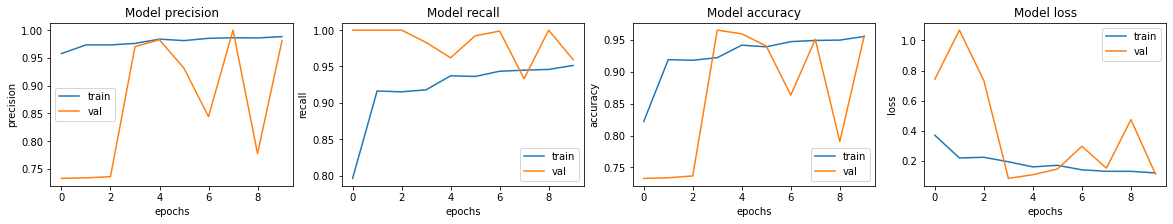

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

모델 평가를 위한 loss, accuracy, precision,recall 값 출력

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 124ms/step - loss: 0.9217 - accuracy: 0.7532 - precision: 0.7218 - recall: 0.9846
Loss: 0.9217184782028198,
Accuracy: 0.7532051205635071,
Precision: 0.7218044996261597,
Recall: 0.9846153855323792


# STEP2. 폐렴 진단기 성능개선

**1. 실험환경 Set-up**

Batch size, Epoch 등을 변경

In [24]:
BATCH_SIZE = 64  # 배치 크기 변경 (예: 32 → 64)
EPOCHS = 20  # 학습 Epoch 변경 (예: 10 → 20)

In [25]:
print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"EPOCHS: {EPOCHS}")

BATCH_SIZE: 64
EPOCHS: 20


**2. 데이터 준비하기**

원본 데이터를 불러와 전처리 및 배치 구성을 수행합니다.
특히 의료 영상 데이터는 항상 충분하지 않기 때문에, 이를 극복할 방법을 고민해야 합니다.

이전에 다루지 않았던 **데이터 증강(Augmentation)** 기법을 고려할 수 있습니다.
그러나 의료 영상, 특히 X-RAY 이미지의 경우 일반적인 증강 기법이 항상 효과적이지 않을 수 있습니다.
육안으로도 구별하기 어려운 미세한 차이에 노이즈가 추가되면 모델 성능이 저하될 가능성이 있기 때문입니다.
따라서 증강 기법을 신중하게 선택하는 것이 중요합니다.

예를 들어, 좌우 반전 정도의 간단한 증강(Augmentation)을 적용한다면, 다음과 같은 방식으로 진행할 수 있습니다.

In [26]:
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
import os, re
warnings.filterwarnings(action='ignore')

# 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

# 데이터 경로
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트에서 변경할 변수
BATCH_SIZE = 64  # 배치 크기 조정 (기존: 16 → 64)
EPOCHS = 20  # 학습 Epoch 조정 (기존: 10 → 20)

print(f"BATCH_SIZE: {BATCH_SIZE}, EPOCHS: {EPOCHS}")

# 파일 불러오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train과 val 데이터를 합쳐 8:2로 분할
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)

train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# 라벨 생성 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 True, 정상(False)

# 이미지 전처리 함수
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  
    img = tf.image.convert_image_dtype(img, tf.float32)  
    img = tf.image.resize(img, IMAGE_SIZE)  
    return img

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# Augmentation 함수 (좌우 반전, 밝기 조절, 대비 조절)
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # 좌우 반전
    image = tf.image.random_brightness(image, max_delta=0.1)  # 밝기 조절
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # 대비 조절
    return image, label

# 데이터셋 로드
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 데이터 전처리 및 배치 구성 함수
def prepare_for_training(ds, shuffle_buffer_size=1000, augment_data=False):
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)  # 증강 적용 (train_ds만)
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

# train_ds에는 Augmentation 적용, val_ds에는 적용 X
train_ds = prepare_for_training(train_ds, augment_data=True)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Test 데이터셋 준비
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# 데이터 확인
print(f"Training images count: {TRAIN_IMG_COUNT}")
print(f"Validation images count: {VAL_IMG_COUNT}")
print(f"Test images count: {TEST_IMG_COUNT}")

# 모델 훈련
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

BATCH_SIZE: 64, EPOCHS: 20
Training images count: 4185
Validation images count: 1047
Test images count: 624
Epoch 1/20
65/65 [==============================] - 54s 669ms/step - loss: 0.4628 - accuracy: 0.7767 - precision: 0.9490 - recall: 0.7394 - val_loss: 0.5825 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/20
65/65 [==============================] - 43s 674ms/step - loss: 0.2373 - accuracy: 0.9005 - precision: 0.9769 - recall: 0.8874 - val_loss: 0.7255 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/20
65/65 [==============================] - 45s 697ms/step - loss: 0.1890 - accuracy: 0.9293 - precision: 0.9781 - recall: 0.9256 - val_loss: 0.9154 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 4/20
65/65 [==============================] - 42s 657ms/step - loss: 0.1526 - accuracy: 0.9433 - precision: 0.9831 - recall: 0.9399 - val_loss: 1.0557 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

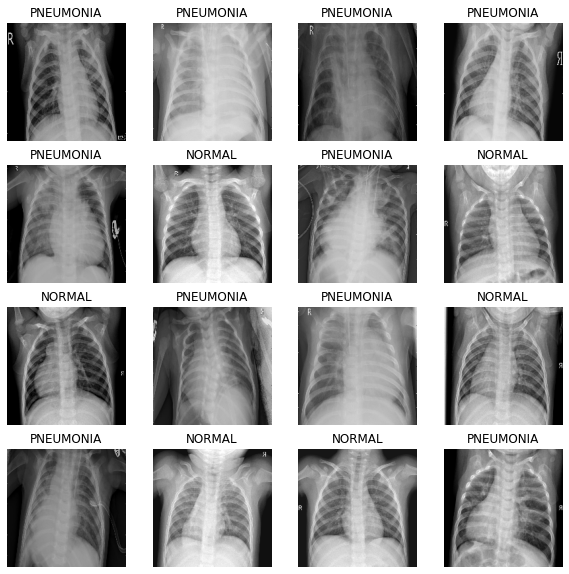

In [27]:
def show_batch(image_batch, label_batch, num_images=16):
    plt.figure(figsize=(10, 10))
    grid_size = math.ceil(math.sqrt(num_images))  # 정사각형 형태로 배치
    
    for n in range(num_images):  # 최대 num_images개만 출력
        ax = plt.subplot(grid_size, grid_size, n + 1)
        plt.imshow(image_batch[n].numpy())  # 이미지를 NumPy 배열로 변환하여 출력
        plt.title("PNEUMONIA" if label_batch[n].numpy() else "NORMAL")
        plt.axis("off")

    plt.show()

# 배치에서 데이터 가져와서 시각화 실행 (Augmentation 적용된 데이터 확인 가능)
for image_batch, label_batch in train_ds.take(1):  # 하나의 배치만 가져옴
    show_batch(image_batch, label_batch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

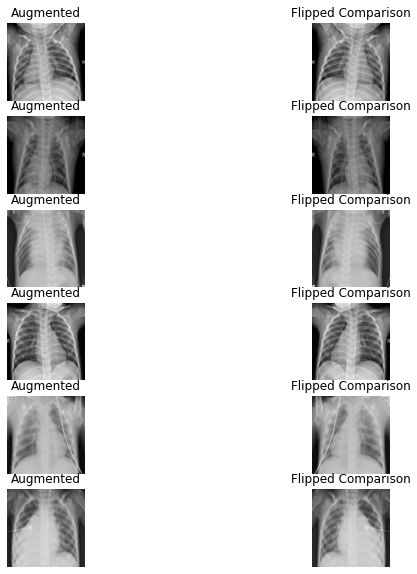

In [28]:
def show_augmented_vs_original(dataset, num_images=6):
    plt.figure(figsize=(10, 10))
    
    for image_batch, label_batch in dataset.take(1):  # Augmentation이 적용된 배치 가져오기
        for i in range(num_images):
            original_image = image_batch[i]  # Augmentation 적용된 이미지
            flipped_image = tf.image.flip_left_right(original_image)  # 좌우 반전 (기준 비교)

            # 원본(=Augmentation 적용) 이미지 출력
            plt.subplot(num_images, 2, 2 * i + 1)
            plt.imshow(original_image.numpy())
            plt.title("Augmented")
            plt.axis("off")

            # 인위적으로 좌우 반전하여 비교
            plt.subplot(num_images, 2, 2 * i + 2)
            plt.imshow(flipped_image.numpy())
            plt.title("Flipped Comparison")
            plt.axis("off")

    plt.show()

# 좌우 반전 비교 실행 (train_ds에서 Augmentation 확인)
show_augmented_vs_original(train_ds)

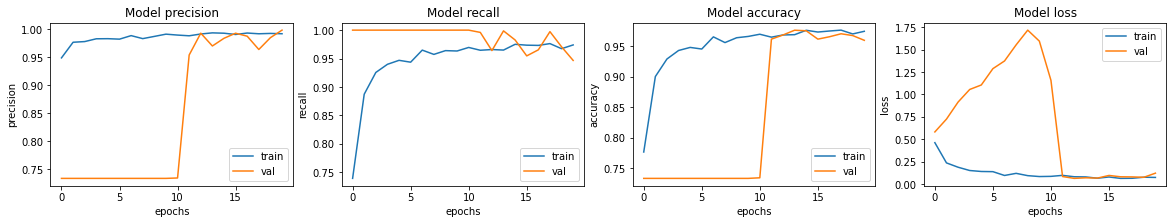

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [30]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 5s 509ms/step - loss: 0.5790 - accuracy: 0.8237 - precision: 0.7966 - recall: 0.9641
Loss: 0.5789767503738403,
Accuracy: 0.8237179517745972,
Precision: 0.7966101765632629,
Recall: 0.964102566242218


In [32]:
def build_new_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.3),  # Dropout 추가

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),  # Dropout 추가

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 새로운 모델 생성
new_model = build_new_model()

# 새로운 모델 컴파일
new_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [33]:
with tf.device('/GPU:0'):
    new_history = new_model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
65/65 [==============================] - 54s 635ms/step - loss: 0.2435 - accuracy: 0.8786 - precision: 0.9748 - recall: 0.8594 - val_loss: 2.4915 - val_accuracy: 0.3047 - val_precision: 1.0000 - val_recall: 0.0519
Epoch 2/20
65/65 [==============================] - 43s 665ms/step - loss: 0.1377 - accuracy: 0.9433 - precision: 0.9831 - recall: 0.9399 - val_loss: 0.1879 - val_accuracy: 0.9238 - val_precision: 0.9912 - val_recall: 0.9041
Epoch 3/20
65/65 [==============================] - 41s 639ms/step - loss: 0.1025 - accuracy: 0.9553 - precision: 0.9882 - recall: 0.9512 - val_loss: 0.3435 - val_accuracy: 0.8955 - val_precision: 0.8788 - val_recall: 0.9947
Epoch 4/20
65/65 [==============================] - 41s 634ms/step - loss: 0.0924 - accuracy: 0.9656 - precision: 0.9910 - recall: 0.9625 - val_loss: 0.1604 - val_accuracy: 0.9473 - val_precision: 0.9888 - val_recall: 0.9387
Epoch 5/20
65/65 [==============================] - 40s 617ms/step - loss: 0.0769 - accuracy: 0.9688

In [ ]:
final_epoch = EPOCHS - 1  # 마지막 에포크 인덱스

# Precision, Recall 가져오기 (없을 경우 대비)
train_precision = new_history.history.get('precision', [None])[final_epoch]
train_recall = new_history.history.get('recall', [None])[final_epoch]
val_precision = new_history.history.get('val_precision', [None])[final_epoch]
val_recall = new_history.history.get('val_recall', [None])[final_epoch]

# F1-score 계산 (2 * (precision * recall) / (precision + recall))
train_f1 = (2 * train_precision * train_recall) / (train_precision + train_recall) if train_precision and train_recall else None
val_f1 = (2 * val_precision * val_recall) / (val_precision + val_recall) if val_precision and val_recall else None

# 결과 출력
print(f"Final Training Loss: {new_history.history['loss'][final_epoch]:.4f}")
print(f"Final Training Accuracy: {new_history.history['accuracy'][final_epoch]:.4f}")
print(f"Final Training Precision: {train_precision:.4f}" if train_precision else "Final Training Precision: Not Available")
print(f"Final Training Recall: {train_recall:.4f}" if train_recall else "Final Training Recall: Not Available")
print(f"Final Training F1-score: {train_f1:.4f}" if train_f1 else "Final Training F1-score: Not Available")

print(f"Final Validation Loss: {new_history.history['val_loss'][final_epoch]:.4f}")
print(f"Final Validation Accuracy: {new_history.history['val_accuracy'][final_epoch]:.4f}")
print(f"Final Validation Precision: {val_precision:.4f}" if val_precision else "Final Validation Precision: Not Available")
print(f"Final Validation Recall: {val_recall:.4f}" if val_recall else "Final Validation Recall: Not Available")
print(f"Final Validation F1-score: {val_f1:.4f}" if val_f1 else "Final Validation F1-score: Not Available")

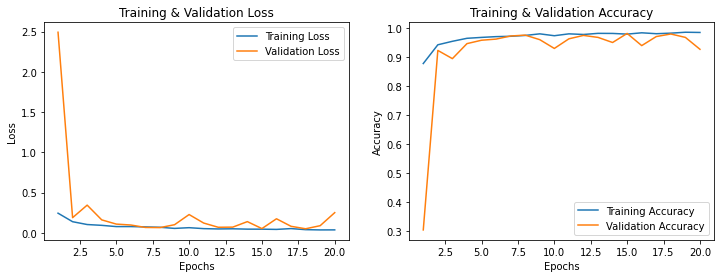

In [35]:
import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, new_history.history['loss'], label='Training Loss')
plt.plot(epochs_range, new_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, new_history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, new_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.show()

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x  

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def ResNet18_Light(input_shape=(224, 224, 3), num_classes=1):  
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(16, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)  # 🔥 필터 개수 16
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, 16) 
    x = residual_block(x, 16)

    x = residual_block(x, 32, stride=2)  
    x = residual_block(x, 32)

    x = residual_block(x, 64, stride=2)  
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2) 
    x = residual_block(x, 128)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)  # 🔥 기존 1000 → 256
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)  

    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)  # 🔥 기존 512 → 128
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)  

    outputs = layers.Dense(1, activation='sigmoid', dtype="float32")(x)  # 🔥 Softmax → Sigmoid (Binary Classification)

    model = Model(inputs, outputs, name="ResNet18_Light")
    return model

# 모델 생성 및 컴파일
model_light = ResNet18_Light()
model_light.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),  # 🔥 Adam 사용
    loss='binary_crossentropy',  # 🔥 Binary Classification 최적화
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

# 모델 요약 출력
model_light.summary()

Model: "ResNet18_Light"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 112, 112, 16) 2352        input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_162 (BatchN (None, 112, 112, 16) 64          conv2d_150[0][0]                 
__________________________________________________________________________________________________
re_lu_119 (ReLU)                (None, 112, 112, 16) 0           batch_normalization_162[0][0]    
_____________________________________________________________________________________

In [44]:

# 🔹 K-Fold 학습 설정
batch_size = 64
fold_no = 1
val_acc_per_fold = []
val_loss_per_fold = []

for train_idx, val_idx in kf.split(train_image_paths, train_labels):
    print(f"\n🔹 Fold {fold_no}")

    # 데이터셋 분할
    train_ds = prepare_dataset(train_image_paths[train_idx], train_labels[train_idx], batch_size)
    val_ds = prepare_dataset(train_image_paths[val_idx], train_labels[val_idx], batch_size)

    # 모델 생성
    model = ResNet18_Light()

    # Early Stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True, verbose=1
    )

    # 모델 컴파일
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )

    # 모델 학습
    history = model.fit(
        train_ds, validation_data=val_ds,  
        epochs=10, verbose=1,
        callbacks=[early_stopping]
    )

    # 성능 저장
    val_acc_per_fold.append(history.history['val_accuracy'][-1])
    val_loss_per_fold.append(history.history['val_loss'][-1])

    print(f"✔ Fold {fold_no} - Accuracy: {val_acc_per_fold[-1]:.4f}, Loss: {val_loss_per_fold[-1]:.4f}")
    fold_no += 1

# 🔹 최종 결과 정리
df_results = pd.DataFrame({
    'Fold': list(range(1, fold_no)),
    'Validation Accuracy': val_acc_per_fold,
    'Validation Loss': val_loss_per_fold
})

df_results.loc['Average'] = ['-', np.mean(val_acc_per_fold), np.mean(val_loss_per_fold)]
print("\n🔹 K-Fold Cross Validation Results:")
print(df_results)


🔹 Fold 1
Epoch 1/10
66/66 [==============================] - 23s 296ms/step - loss: 2.5519 - accuracy: 0.5070 - precision: 0.7523 - recall: 0.5074 - val_loss: 2.1511 - val_accuracy: 0.7251 - val_precision: 0.7251 - val_recall: 1.0000
Epoch 2/10
66/66 [==============================] - 19s 290ms/step - loss: 2.2737 - accuracy: 0.5218 - precision: 0.7589 - recall: 0.5279 - val_loss: 2.0308 - val_accuracy: 0.5603 - val_precision: 0.6757 - val_recall: 0.7569
Epoch 3/10
66/66 [==============================] - 19s 288ms/step - loss: 2.1073 - accuracy: 0.5331 - precision: 0.7431 - recall: 0.5734 - val_loss: 1.8191 - val_accuracy: 0.7251 - val_precision: 0.7251 - val_recall: 1.0000
Epoch 4/10
66/66 [==============================] - 19s 290ms/step - loss: 1.9736 - accuracy: 0.5604 - precision: 0.7496 - recall: 0.6183 - val_loss: 1.8065 - val_accuracy: 0.7251 - val_precision: 0.7251 - val_recall: 1.0000
Epoch 5/10
66/66 [==============================] - 19s 291ms/step - loss: 1.8625 - accura

회고: 마지막 ResNet18의 성능이 70퍼센트 밖에 나오지 않지만 시간이 없어 일단 제출한다 ㅠㅠ. 더 공부해 봐야겠다. 